## Currently this notebook is an illustration for Adonis.

In [37]:
from iqm.qiskit_iqm.iqm_transpilation import optimize_single_qubit_gates

##########################################################################
from iqm.benchmarks.entanglement.graph_states import generate_graph_state
from iqm.benchmarks.shadow_utils import *
from iqm.benchmarks.utils import get_iqm_backend , set_coupling_map
##########################################################################

from qiskit import ClassicalRegister, transpile

from rustworkx.visualization import mpl_draw
from rustworkx import spring_layout
import matplotlib.pyplot as plt
import matplotlib as mpl

import json

mpl.rcParams['figure.dpi'] = 300

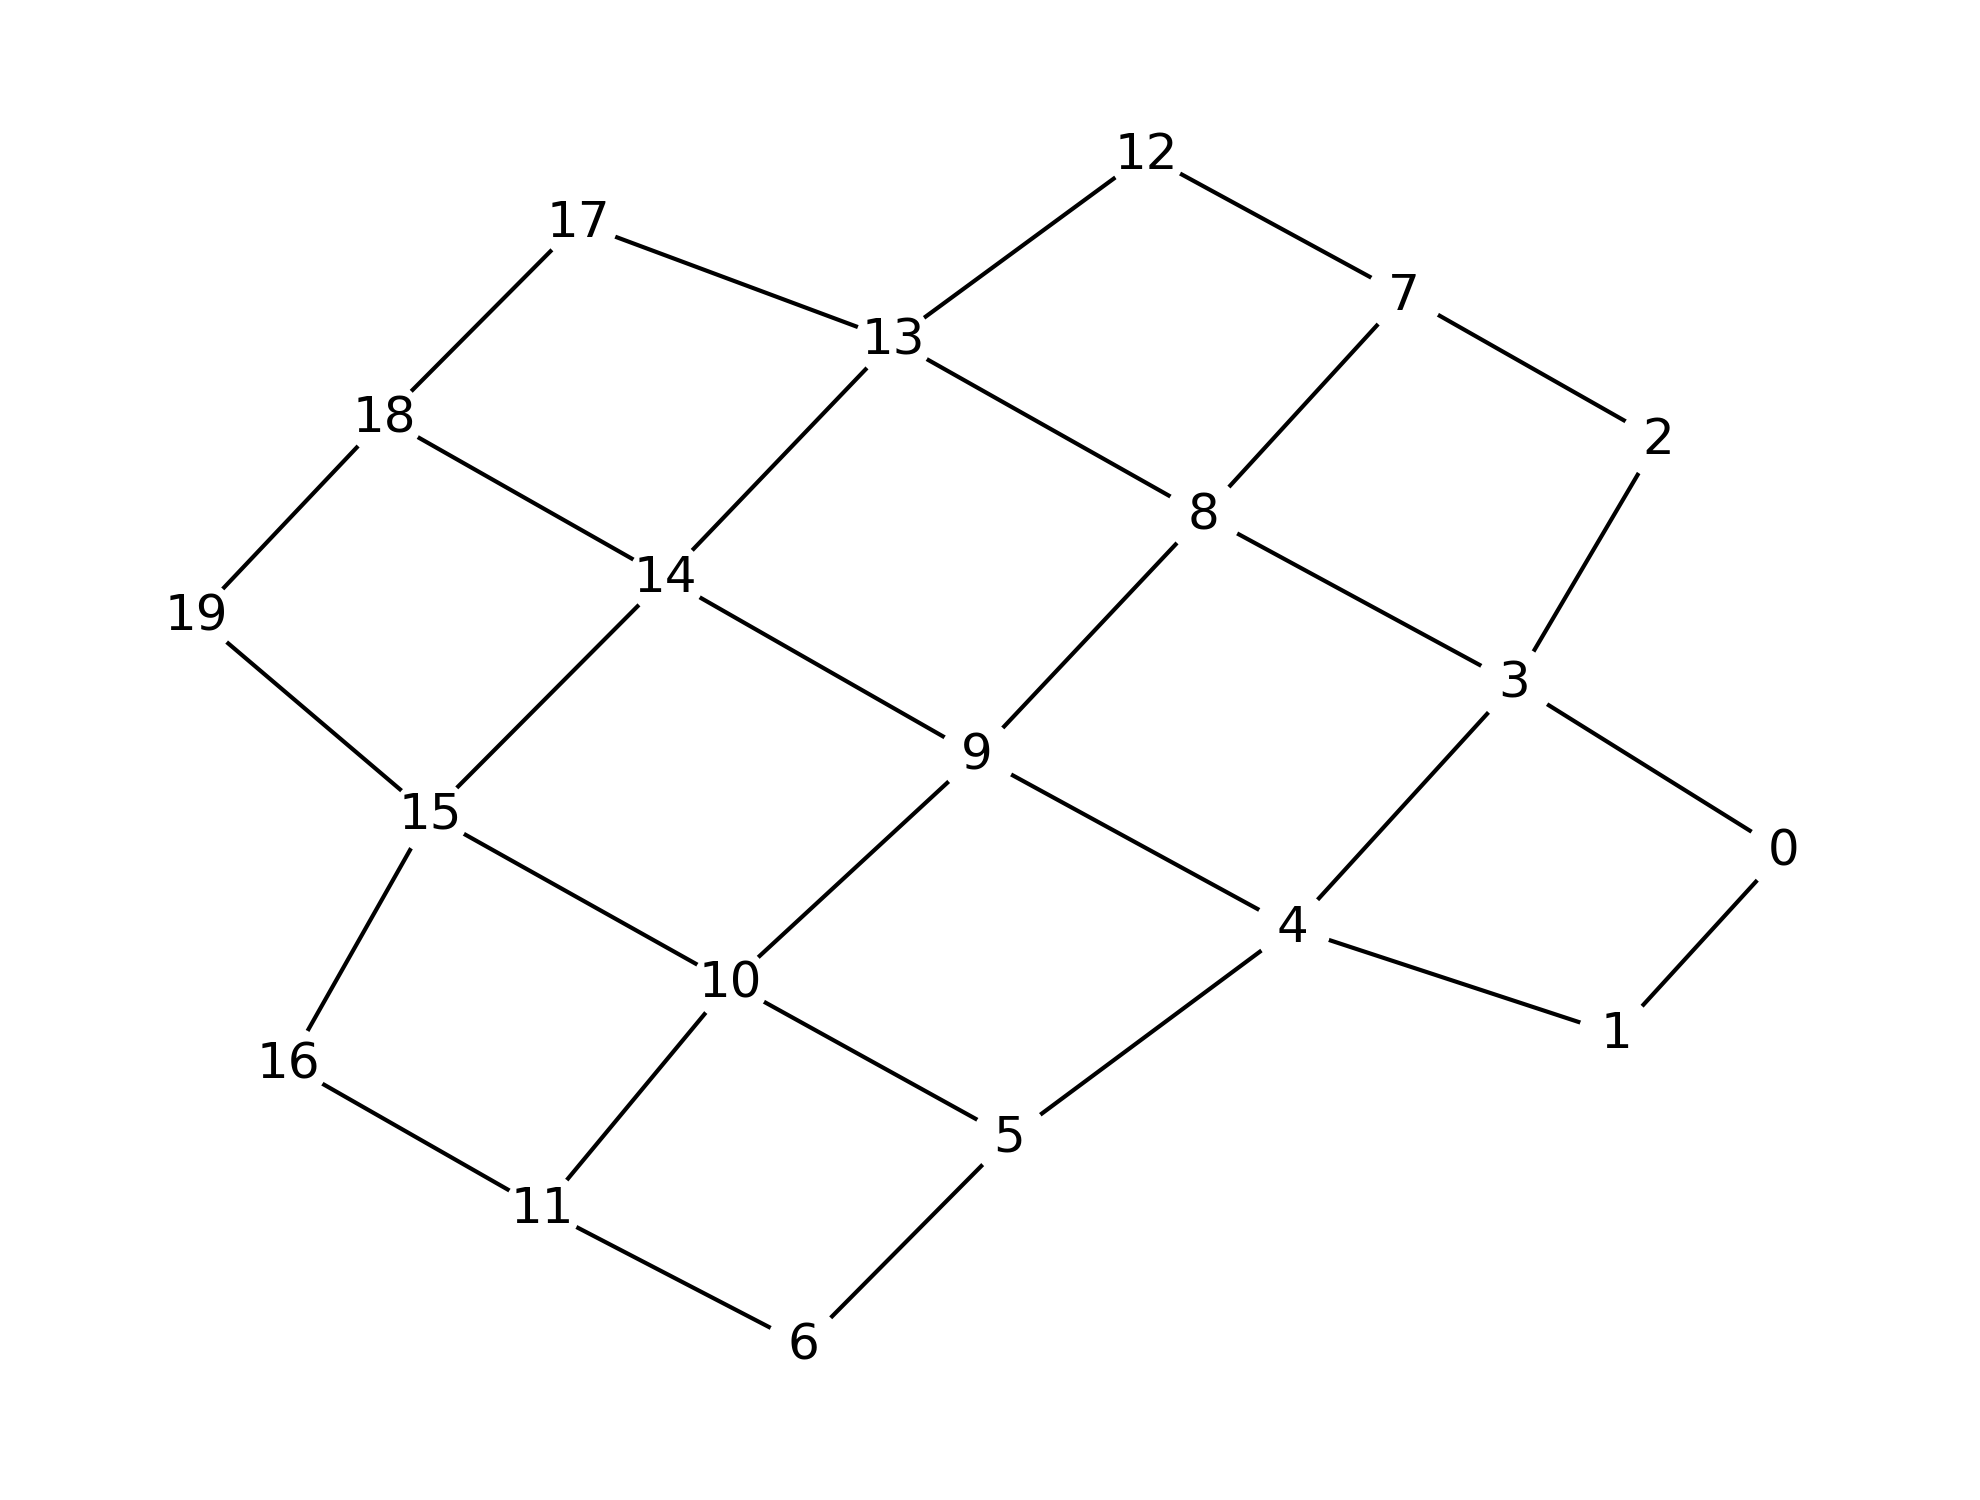

In [40]:
## initiate the backend
# import os
# from iqm.qiskit_iqm import IQMProvider
# os.environ["IQM_TOKEN"] = "fwBucKQFFBYvcynSpatCvgEEEt0faj4RVc7P45XtXUMGdgTJ0WV9L4AAMQzHVeFl"
# QPU = 'pyrite'
# #iqm_server_url = "https://pluto.mx05.iqm.fi/cocos"
#
# if QPU == 'aphrodite':
#     iqm_server_url = "https://fqcp3-host1.xld09.iqm.fi/cocos"
#     provider = IQMProvider(iqm_server_url)
#     backend = provider.get_backend()
#     layout = [1,5,4,6,11]
#     reduced_coupling_map = backend.coupling_map.reduce(mapping=layout)
#     sub_system = list(reduced_coupling_map)
# else:
#     iqm_server_url = 'https://cocos.resonance.meetiqm.com/' + QPU
#     provider = IQMProvider(iqm_server_url)
#     backend = provider.get_backend()

import os
os.environ["IQM_TOKEN"] = "y396X7OKLE55x56Bz+1l/G7AnIR1zZELJkYfsN5tjqQGXpmiD0J54IAApraILJRA"
backend = get_iqm_backend("garnet")
cmap = backend.coupling_map
mpl_draw(cmap.graph.to_undirected(multigraph=False), arrows=True, with_labels=True, node_color='w', pos=spring_layout(backend.coupling_map.graph, num_iter=200))

In [41]:
list(backend.coupling_map.reduce([4,8,10,9,14]))

[(3, 0), (0, 3), (3, 1), (1, 3), (3, 2), (2, 3), (3, 4), (4, 3)]

**Original functions commented below; now importing them from the package**

**NB**: `find_maximal_edge_set` is now renamed to `find_pairs_with_disjoint_neighbors`

In [3]:
# from collections import defaultdict
#
# def find_maximal_edge_set(graph):
#     # Build adjacency list representation of the graph
#     adjacency = defaultdict(set)
#     for u, v in graph:
#         adjacency[u].add(v)
#         adjacency[v].add(u)
#
#     # Function to get neighboring nodes of an edge
#     def get_edge_neighbors(edge):
#         u, v = edge
#         return (adjacency[u] | adjacency[v]) - {u, v}
#
#     remaining_edges = set(graph)  # Keep track of remaining edges
#     iterations = []  # Store the edges chosen in each iteration
#
#     while remaining_edges:
#         current_iteration = set()  # Edges chosen in this iteration
#         used_nodes = set()  # Nodes already used in this iteration
#
#         for edge in list(remaining_edges):
#             u, v = edge
#             # Check if the edge is disconnected from already chosen edges
#             if u in used_nodes or v in used_nodes:
#                 continue
#
#             # Get neighboring nodes of this edge
#             edge_neighbors = get_edge_neighbors(edge)
#
#             # Check if any neighbor belongs to an edge already in this iteration
#             if any(neighbor in used_nodes for neighbor in edge_neighbors):
#                 continue
#
#             # Add the edge to the current iteration
#             current_iteration.add(edge)
#             used_nodes.update([u, v])
#
#         # Add the chosen edges to the result
#         iterations.append(list(current_iteration))
#         remaining_edges -= current_iteration  # Remove chosen edges from the remaining edges
#
#     return iterations


# def get_neighbors_of_edges(edges, graph_edges):
#     """
#     Given a list of edges and a graph, return all neighboring nodes of the edges.
#     """
#     neighboring_nodes = set()
#     nodes_in_edges = set()
#
#     for u, v in edges:
#         nodes_in_edges.add(u)
#         nodes_in_edges.add(v)
#
#     for x, y in graph_edges:
#         if x in nodes_in_edges:
#             neighboring_nodes.add(y)
#         if y in nodes_in_edges:
#             neighboring_nodes.add(x)
#     neighboring_nodes -= nodes_in_edges
#
#     return list(neighboring_nodes)

# def project_neighbouring_qubits(qc, num_cregs, meas_qubit):
#     qc_copy = qc.copy()
#     qc_copy.barrier()
#     register = ClassicalRegister(num_cregs)
#     qc_copy.add_register(register)
#     for idx, iq in enumerate(meas_qubit):
#         qc_copy.measure(iq, register[idx])
#     return qc_copy

In [4]:
from iqm.benchmarks.utils import project_qubits, get_neighbors_of_edges, find_edges_with_disjoint_neighbors

num_qubits = backend.num_qubits
qubits = list(range(num_qubits))

qc = generate_graph_state(qubits, backend=backend)

#new_cmap = [v for i, v in enumerate(list(cmap)) if i % 2 == 0]
reduced_cmap = set_coupling_map(qubits, backend, physical_layout="fixed")
graph_edges = list(reduced_cmap.graph.to_undirected(multigraph=False).edge_list())

## store state_vector
# import qiskit.quantum_info as qi
# stv_graph = np.array(qi.Statevector.from_instruction(qc))
# rho_graph = np.einsum('i, j -> ij', np.conjugate(stv_graph.T), stv_graph)

# run_iterations = find_edges_with_disjoint_neighbors(graph_edges)
# num_iterations = len(run_iterations)

pair_groups = find_edges_with_disjoint_neighbors(graph_edges)
num_pair_groups = len(pair_groups)
indexed_qubit_pairs = {idx : [a for b in x for a in b] for idx, x in enumerate(pair_groups)}
projected_nodes = {idx: get_neighbors_of_edges(list(x), graph_edges) for idx, x in enumerate(pair_groups)}
qc_dict = {idx: project_qubits(qc, x) for idx, x in projected_nodes.items()}

In [5]:
# qc.draw(output='mpl', style='clifford')

In [6]:
pair_groups

[[(11, 10), (18, 17), (7, 12), (3, 4)],
 [(13, 8), (11, 16), (5, 4), (18, 19)],
 [(1, 0), (13, 14), (5, 10), (7, 2)],
 [(15, 16), (5, 6), (9, 8)],
 [(11, 6), (9, 14), (3, 0)],
 [(15, 19), (13, 17), (9, 4)],
 [(3, 2), (15, 14)],
 [(9, 10), (13, 12)],
 [(15, 10), (3, 8)],
 [(7, 8), (1, 4), (18, 14)]]

In [7]:
print("{index, qubit pairs}:")
print(indexed_qubit_pairs)

{index, qubit pairs}:
{0: [11, 10, 18, 17, 7, 12, 3, 4], 1: [13, 8, 11, 16, 5, 4, 18, 19], 2: [1, 0, 13, 14, 5, 10, 7, 2], 3: [15, 16, 5, 6, 9, 8], 4: [11, 6, 9, 14, 3, 0], 5: [15, 19, 13, 17, 9, 4], 6: [3, 2, 15, 14], 7: [9, 10, 13, 12], 8: [15, 10, 3, 8], 9: [7, 8, 1, 4, 18, 14]}


In [8]:
print("{index, projected nodes}:")
print(projected_nodes)

{index, projected nodes}:
{0: [0, 1, 2, 5, 6, 8, 9, 13, 14, 15, 16, 19], 1: [1, 3, 6, 7, 9, 10, 12, 14, 15, 17], 2: [3, 4, 6, 8, 9, 11, 12, 15, 17, 18], 3: [3, 4, 7, 10, 11, 13, 14, 19], 4: [1, 2, 4, 5, 8, 10, 13, 15, 16, 18], 5: [1, 3, 5, 8, 10, 12, 14, 16, 18], 6: [0, 4, 7, 8, 9, 10, 13, 16, 18, 19], 7: [4, 5, 7, 8, 11, 14, 15, 17], 8: [0, 2, 4, 5, 7, 9, 11, 13, 14, 16, 19], 9: [0, 2, 3, 5, 9, 12, 13, 15, 17, 19]}


In [9]:
get_neighbors_of_edges([(12, 13)], graph_edges)

[7, 8, 14, 17]

In [10]:
# for q in qc_dict.values():
#     display(q.draw(output='mpl', style='clifford', fold=0))

In [19]:
Nu = 50 ## number of random unitaries used
Nm = 2**11 ## number of measurements per random unitary
#counts_list = []
rm_trans = {}
all_unitaries = {}
all_jobs = {}
for counter, (idx, circs) in enumerate(qc_dict.items()):
    rm_qubits = indexed_qubit_pairs[idx]
    all_unitaries[idx], rm_circs = haar_shadow_tomography(circs, Nu, rm_qubits)
    rm_trans[idx] = [optimize_single_qubit_gates(transpile(qcc, backend), drop_final_rz=True) for qcc in rm_circs]
    # With Apollo or bigger need to run on real hardware
    #print(f"Now submitting job {counter+1}/{len(qc_dict.values())}")
    #all_jobs[idx] = backend.run(rm_trans, shots = Nm)

In [12]:
# all_counts = {}
# for idx, job in all_jobs.items():
#     print(f"Now retrieving counts of job {idx+1}/{len(all_jobs)}")
#     all_counts[idx] = job.result().get_counts()

In [13]:
#all_counts

In [14]:
# import json
# with open('garnet_graph_counts.json', 'w') as f:
#     json.dump(all_counts, f)

In [17]:
with open('garnet_graph_counts.json') as f:
    all_counts_f = json.load(f)

**Beware the keys from the loaded dictionary become strings!**

**And the RM register corresponds to the first bitstring from left to right, e.g. '0000 101000' refers to '0000' in RM register, '101000' in projection register**

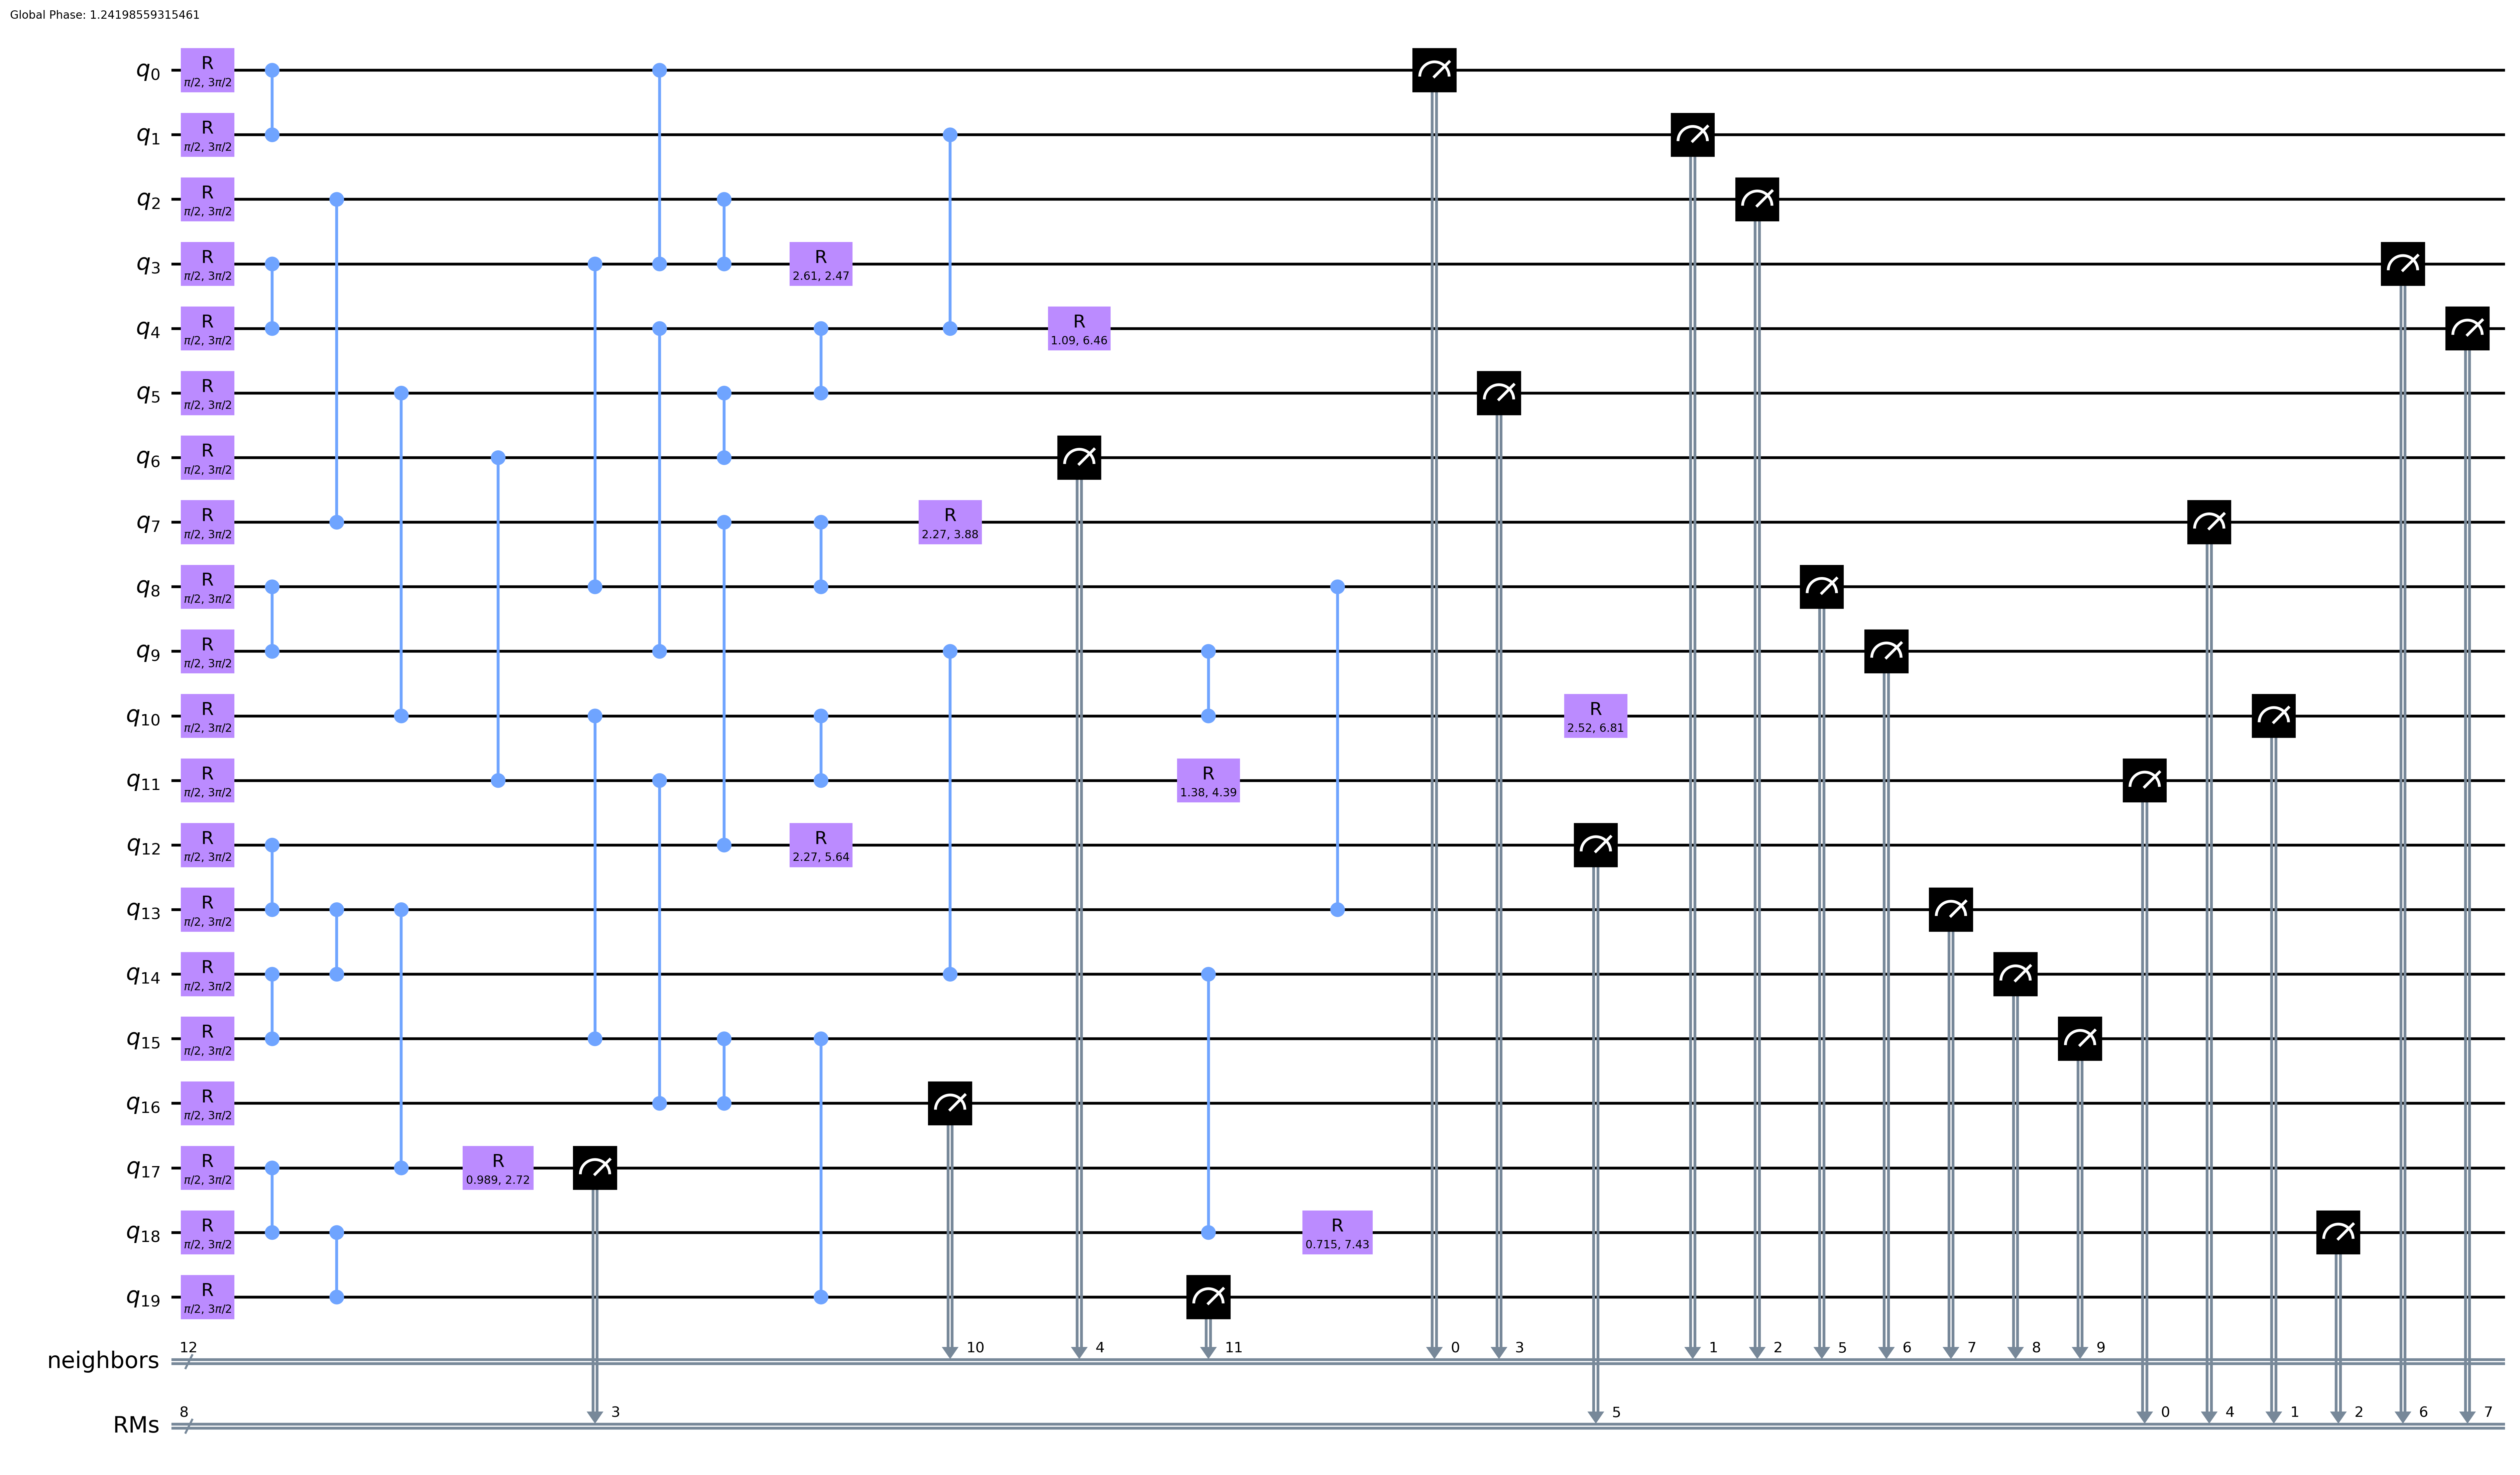

In [20]:
rm_trans[0][0].draw(output='mpl', style='clifford', fold=0)

In [21]:
all_counts_f[str(0)][0]

{'01011001 110010110100': 1,
 '11000010 111110011011': 1,
 '11000000 110000101010': 1,
 '10010001 011111000000': 1,
 '01101000 011101100000': 1,
 '11001011 110100001010': 1,
 '00001001 011111011011': 1,
 '10101101 010111111101': 1,
 '11111001 010100110000': 1,
 '00100000 011101001100': 1,
 '00111011 000100001010': 1,
 '00110100 010011000001': 1,
 '11100001 011000101011': 1,
 '11110000 010000101111': 1,
 '10011001 111101110001': 1,
 '00100010 011100101001': 1,
 '00001100 101110100110': 1,
 '10110011 010110011111': 1,
 '01100100 110101001000': 1,
 '10110010 110100001001': 1,
 '10000011 001101110101': 1,
 '10110000 001011001001': 1,
 '10001000 000010111001': 1,
 '11100100 001001101110': 1,
 '10001000 011010011111': 1,
 '00100010 000111001001': 1,
 '10001101 111011011100': 1,
 '00100010 101110100000': 1,
 '10100010 111101000100': 1,
 '00010000 110010011000': 1,
 '00110110 010100110100': 1,
 '10100101 111111111001': 1,
 '01111000 000011111100': 1,
 '01110010 001110011010': 1,
 '10111111 111

In [33]:
from qiskit_aer import AerSimulator
simulator = AerSimulator()
circ = transpile(qc, simulator)
result = simulator.run(qc).result()
counts = result.get_counts(qc)

qc = QuantumCircuit(2,1)
qc.add_register(ClassicalRegister(1, "special_reg"))
qc.h(0)
qc.h(1)
qc.cz(0,1)
qc.measure([0,1],[0,1])
display(qc.draw())
print(result)
print(counts)

┌───┐   ┌─┐   
          q_0: ┤ H ├─■─┤M├───
               ├───┤ │ └╥┘┌─┐
          q_1: ┤ H ├─■──╫─┤M├
               └───┘    ║ └╥┘
          c: 1/═════════╩══╬═
                        0  ║ 
special_reg: 1/════════════╩═
                           0

Result(backend_name='aer_simulator', backend_version='0.14.2', qobj_id='', job_id='66c6c110-0386-421d-b0d7-9f44e2dc0d4c', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1': 248, '0x2': 243, '0x0': 261, '0x3': 272}), header=QobjExperimentHeader(creg_sizes=[['c', 1], ['special_reg', 1]], global_phase=0.0, memory_slots=2, n_qubits=2, name='circuit-2181', qreg_sizes=[['q', 2]], metadata={}), status=DONE, seed_simulator=1161135065, metadata={'batched_shots_optimization': False, 'required_memory_mb': 0, 'method': 'stabilizer', 'active_input_qubits': [0, 1], 'device': 'CPU', 'remapped_qubits': False, 'num_qubits': 2, 'num_clbits': 2, 'time_taken': 0.0026311, 'sample_measure_time': 0.0012027, 'input_qubit_map': [[0, 0], [1, 1]], 'max_memory_mb': 32487, 'measure_sampling': True, 'noise': 'ideal', 'parallel_shots': 1, 'parallel_state_update': 8, 'runtime_parameter_bind': False, 'num_bind_params': 1, 'fusion': {'enabled': False

# post-processing code 

In [12]:
# neighbour_qubits = 3
# neigbour_bit_strings = [' ' + format(x, '0'+str(neighbour_qubits)+'b') for x in range(2**neighbour_qubits)] # list of strings of the remaining 3 neighbouring qubits
# counts_bit = [] ## counts of the edge of interest in the graph for all possible combination of the neighbouring qubits

# for ibit in neigbour_bit_strings:
#     counts_group = []
#     for iu in range(num_iterations):
#         counts_per_batch = []
#         for iq in range(len(counts_list[iu])):
#             counts_new = {}
#             for inm, ist in enumerate(counts_list[iu][iq].keys()):
#                 if (ist[-4:] == ibit):
#                     counts_new[ist[0:5]] = counts_list[iu][iq][ist]
#             counts_per_batch.append(counts_new)
#         counts_group.append(counts_per_batch)
#     counts_bit.append(counts_group)

In [32]:
neighbor_num_qubits = {idx: len(x) for idx, x in projected_nodes.items()}
neighbor_bit_strings = {idx: [' ' + format(x, '0'+str(n)+'b') for x in range(2**n)] for idx, n in neighbor_num_qubits.items()} 

In [33]:
print("{index: total # of projected qubits}")
print(neighbor_num_qubits)

{index: total # of projected qubits}
{0: 12, 1: 10, 2: 10, 3: 8, 4: 10, 5: 9, 6: 10, 7: 8, 8: 11, 9: 10}


In [34]:
print("{index: projected bitstrings}")
print(neighbor_bit_strings)

{index: projected bitstrings}
{0: [' 000000000000', ' 000000000001', ' 000000000010', ' 000000000011', ' 000000000100', ' 000000000101', ' 000000000110', ' 000000000111', ' 000000001000', ' 000000001001', ' 000000001010', ' 000000001011', ' 000000001100', ' 000000001101', ' 000000001110', ' 000000001111', ' 000000010000', ' 000000010001', ' 000000010010', ' 000000010011', ' 000000010100', ' 000000010101', ' 000000010110', ' 000000010111', ' 000000011000', ' 000000011001', ' 000000011010', ' 000000011011', ' 000000011100', ' 000000011101', ' 000000011110', ' 000000011111', ' 000000100000', ' 000000100001', ' 000000100010', ' 000000100011', ' 000000100100', ' 000000100101', ' 000000100110', ' 000000100111', ' 000000101000', ' 000000101001', ' 000000101010', ' 000000101011', ' 000000101100', ' 000000101101', ' 000000101110', ' 000000101111', ' 000000110000', ' 000000110001', ' 000000110010', ' 000000110011', ' 000000110100', ' 000000110101', ' 000000110110', ' 000000110111', ' 00000011100

**------ WIP ------- !**

In [40]:
counts_bit = {} ## counts of the edge of interest in the graph for all possible combinations of the neighbouring qubits

# for idx in neighbor_bit_strings.keys():
#     for ibit in neighbor_bit_strings[idx]:
#         counts_group = {}
#         for iu in range(num_pair_groups): # num_pair_groups == len(neighbor_bit_strings.keys()), i.e., total of groups of qubit pairs
#             counts_per_batch = []
#             for iq in range(len(all_counts_f[str(iu)])):
#                 counts_new = {}
#                 for inm, ist in enumerate(counts_list[iu][iq].keys()):
#                     if (ist[-4:] == ibit):
#                         counts_new[ist[0:5]] = counts_list[iu][iq][ist]
#                 counts_per_batch.append(counts_new)
#             counts_group[ibit] = counts_per_batch
#         counts_bit[idx] = counts_group

for idx, group in enumerate(pair_groups):
    #print(f"Group: {idx}: {group}")
    neighbors_to_bitindex = {x: i for i, x in enumerate(sorted(projected_nodes[idx]))}
    #print(neighbors_to_bitindex)
    for pair_idx, pair in enumerate(group):
        print(f"pair: {pair}")
        neighbors = get_neighbors_of_edges([pair], graph_edges)
        print(f"neighbors: {neighbors}")
        bit_indices = [neighbors_to_bitindex[n] for n in neighbors]
        print(f"bit indices: {bit_indices}")
        all_counts_f[str(idx)][]

pair: (11, 10)
neighbors: [5, 6, 9, 15, 16]
bit indices: [3, 4, 6, 9, 10]
pair: (18, 17)
neighbors: [13, 14, 19]
bit indices: [7, 8, 11]
pair: (7, 12)
neighbors: [2, 8, 13]
bit indices: [2, 5, 7]
pair: (3, 4)
neighbors: [0, 1, 2, 5, 8, 9]
bit indices: [0, 1, 2, 3, 5, 6]
pair: (13, 8)
neighbors: [3, 7, 9, 12, 14, 17]
bit indices: [1, 3, 4, 6, 7, 9]
pair: (11, 16)
neighbors: [6, 10, 15]
bit indices: [2, 5, 8]
pair: (5, 4)
neighbors: [1, 3, 6, 9, 10]
bit indices: [0, 1, 2, 4, 5]
pair: (18, 19)
neighbors: [14, 15, 17]
bit indices: [7, 8, 9]
pair: (1, 0)
neighbors: [3, 4]
bit indices: [0, 1]
pair: (13, 14)
neighbors: [8, 9, 12, 15, 17, 18]
bit indices: [3, 4, 6, 7, 8, 9]
pair: (5, 10)
neighbors: [4, 6, 9, 11, 15]
bit indices: [1, 2, 4, 5, 7]
pair: (7, 2)
neighbors: [3, 8, 12]
bit indices: [0, 3, 6]
pair: (15, 16)
neighbors: [10, 11, 14, 19]
bit indices: [3, 4, 6, 7]
pair: (5, 6)
neighbors: [4, 10, 11]
bit indices: [1, 3, 4]
pair: (9, 8)
neighbors: [3, 4, 7, 10, 13, 14]
bit indices: [0, 1, 2

In [22]:
counts_bit

{0: {' 111': [{'00 11': 56, '01 11': 8, '10 11': 13, '11 11': 60},
   {'00 11': 21, '01 11': 38, '11 11': 30, '10 11': 27},
   {'01 11': 36, '00 11': 18, '10 11': 25, '11 11': 25},
   {'10 11': 41, '01 11': 65, '00 11': 17, '11 11': 11},
   {'00 11': 48, '11 11': 44, '01 11': 25, '10 11': 15},
   {'00 11': 53, '11 11': 54, '10 11': 16, '01 11': 25},
   {'10 11': 48, '01 11': 35, '00 11': 17, '11 11': 21},
   {'11 11': 54, '01 11': 24, '00 11': 43, '10 11': 15},
   {'11 11': 32, '00 11': 28, '01 11': 33, '10 11': 35},
   {'11 11': 48, '00 11': 48, '01 11': 13, '10 11': 15}]},
 1: {' 111': [{'00 11': 56, '01 11': 8, '10 11': 13, '11 11': 60},
   {'00 11': 21, '01 11': 38, '11 11': 30, '10 11': 27},
   {'01 11': 36, '00 11': 18, '10 11': 25, '11 11': 25},
   {'10 11': 41, '01 11': 65, '00 11': 17, '11 11': 11},
   {'00 11': 48, '11 11': 44, '01 11': 25, '10 11': 15},
   {'00 11': 53, '11 11': 54, '10 11': 16, '01 11': 25},
   {'10 11': 48, '01 11': 35, '00 11': 17, '11 11': 21},
   {'11 1

In [13]:
## construct shadows for each neighbour_bit_string and each edge of interest.
rho_shadows_all_bits = []

for idx, ibit in enumerate(neigbour_bit_strings):
    rho_shadows = []
    for ib in range(num_iterations):
        nqubits = len(run_iterations[ib][0])
        rho = np.zeros((2**nqubits, 2**nqubits), dtype = complex)
        for iu in range(Nu):
            rho += get_shadow(counts_bit[idx][ib][iu], unitaries_list[ib][iu,:,:,:], list(run_iterations[ib][0]))/Nu
        rho_shadows.append(rho)
    rho_shadows_all_bits.append(rho_shadows)

ValueError: invalid literal for int() with base 10: ' '

In [16]:
## compute the 2 qubit negativity for each of the neighbour bitstrings and groups
neg = [[np.abs(get_negativity(rho_shadows_all_bits[bits][isys], 1, 1)) for bits in range(2**neighbour_qubits)] for isys in range(num_iterations)]
neg_per_edge = [max(x) for x in neg]
get_index = [x.index(max(x)) for x in neg]
max_neg_dm = [rho_shadows_all_bits[get_index[x]][x] for x in range(num_iterations)]

## plot negativity
plt.scatter(list(range(num_iterations)), neg_per_edge)
plt.xticks(list(range(num_iterations)), run_iterations, fontsize=12, rotation=90)
plt.ylabel('Negativity')
plt.xlabel('Edges')

IndexError: list index out of range

In [13]:
## construct ideal rdms after the neighbouring strings have been measured
from qiskit.quantum_info import *
proj = np.zeros((3, 2, 2), dtype=complex)
proj[0, :, :] = np.array([[1, 0], [0, 0]])
proj[1, :, :] = np.array([[0, 0], [0, 1]])
proj[2, :, :] = np.array([[1, 0], [0, 1]])
neigbour_bit_strings = [' ' + format(x, '0'+str(neighbour_qubits)+'b') for x in range(2**neighbour_qubits)] 

reduced_dm_list = []
for iq in range(num_iterations):
    projection = 1
    for bits in range(num_qubits):
        if (bits in projected_nodes[iq]):
            bit_index = list(projected_nodes[iq]).index(bits)
            bit_string = neigbour_bit_strings[get_index[iq]]
            ind = int(bit_string[::-1][bit_index])
            projection = np.kron(projection, proj[ind])
        
        else:
            projection = np.kron(projection, proj[2])
    # projection /= np.trace(projection)
    post_selcted_dm = rho_graph@projection
    post_selcted_dm /= np.trace(post_selcted_dm)
    reduced_dm_list.append(np.array(partial_trace(post_selcted_dm, list(projected_nodes[iq]))))

Text(0.5, 0, 'Edges')

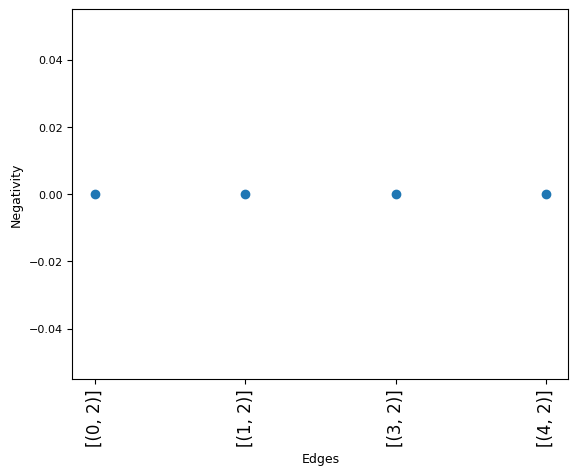

In [14]:
neg_per_edge_ideal = [np.abs(get_negativity(x, 1, 1)) for x in reduced_dm_list]
## plot negativity
plt.scatter(list(range(num_iterations)), neg_per_edge_ideal)
plt.xticks(list(range(num_iterations)), run_iterations, fontsize=12, rotation=90)
plt.ylabel('Negativity')
plt.xlabel('Edges')

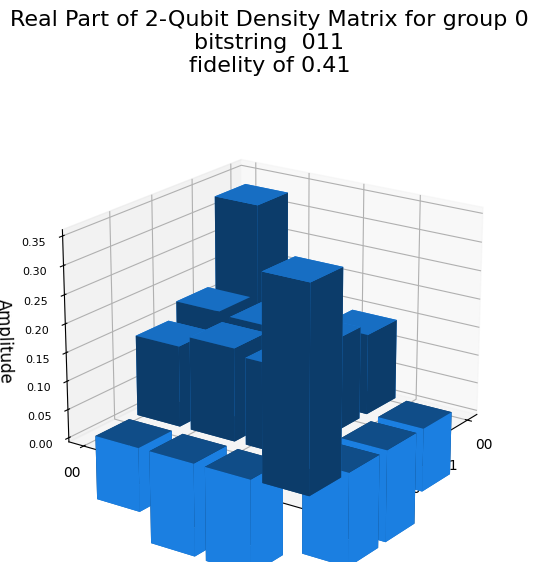

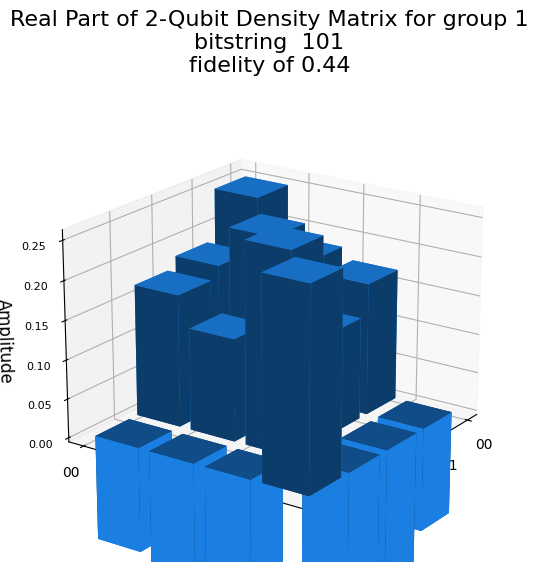

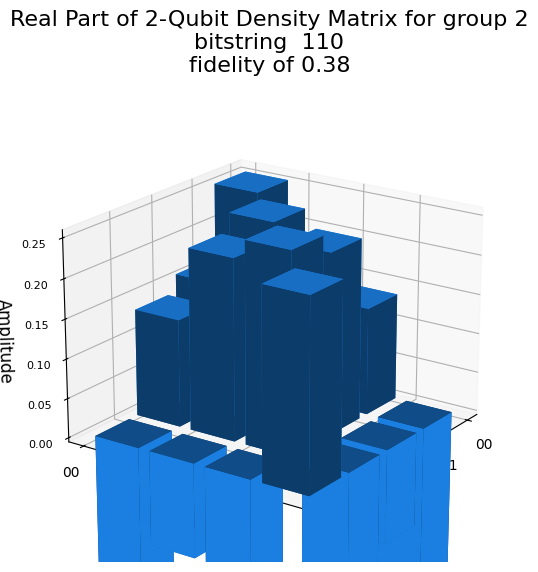

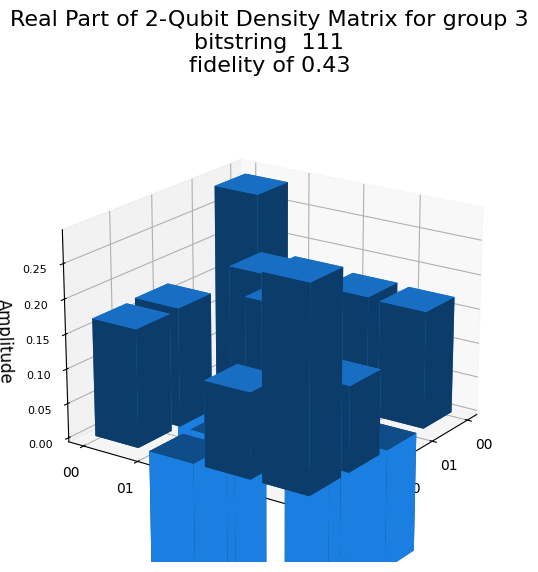

In [18]:
import numpy as np
import matplotlib.pyplot as plt

# Bitstring labels for 2-qubit states
bitstrings = ['00', '01', '10', '11']

# Function to create 3D bar plot
def plot_tomography(matrix, title, color):
    n = matrix.shape[0]
    xpos, ypos = np.meshgrid(np.arange(n), np.arange(n), indexing="ij")
    xpos, ypos = xpos.flatten(), ypos.flatten()
    zpos = np.zeros_like(xpos)

    # Heights of the bars (matrix elements)
    heights = matrix.flatten()

    # Bar dimensions
    dx = dy = 0.8

    # Create the figure
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    # Plot the bars
    ax.bar3d(xpos, ypos, zpos, dx, dy, heights, shade=True, color=color)

    # Set axis labels with bitstrings
    ax.set_xticks(np.arange(n))
    ax.set_yticks(np.arange(n))
    ax.set_xticklabels(bitstrings, fontsize=10)
    ax.set_yticklabels(bitstrings, fontsize=10)

    # Add title and axis labels
    ax.set_title(title, fontsize=16, pad=20)
    ax.set_zlabel("Amplitude", fontsize=12)

    # Set the view angle for better visualization
    ax.view_init(elev=20, azim=35)

    # Show the plot
    #plt.tight_layout()
    plt.show()


# Plot the real part in blue
for iq in range(num_iterations):
    fid = np.trace(max_neg_dm[iq] @ np.array(reduced_dm_list[iq]))
    plot_tomography(np.real(max_neg_dm[iq]), f"Real Part of 2-Qubit Density Matrix for group {iq}\nbitstring {neigbour_bit_strings[get_index[iq]]}\nfidelity of {np.real(fid):.2f}", color="dodgerblue")
    # plot_tomography(np.real(reduced_dm_list[iq]), f"Ideal Real Part of 2-Qubit Density Matrix for group {iq} and bitstring {neigbour_bit_strings[get_index[iq]]}", color="red")